# Monte Carlo Methods

Implementations of many Monte Carlo (MC) algorithms for solving blackjack environment.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum(maximum sum that can be reached without getting bust) $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [4]:
for i_episode in range(3):
    state = env.reset() #start a new game
    while True: 
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        print([state, action, reward])
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

[(17, 3, True), 1, 0]
[(17, 3, True), 0, -1.0]
End game! Reward:  -1.0
You lost :(

[(11, 10, False), 0, -1.0]
End game! Reward:  -1.0
You lost :(

[(14, 5, False), 1, 0]
[(14, 5, False), 0, 1.0]
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Executed the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [6]:
for i in range(7):
    print(generate_episode_from_limit_stochastic(env))

[((7, 1, False), 0, -1.0)]
[((15, 2, False), 0, 1.0)]
[((14, 5, False), 1, -1)]
[((12, 9, False), 1, 0), ((16, 9, False), 1, -1)]
[((16, 7, False), 1, -1)]
[((15, 10, False), 1, -1)]
[((8, 3, False), 1, 0), ((18, 3, False), 1, -1)]


Now we implement MC prediction.  It can be either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent because the same state can't be reached again.

Algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [7]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initializing empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n)) # env.action_space.n returns size of action space
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # if the key(state) passed is not in dict, it will return [0,0]
    # looping over episodes
    for i_episode in range(1, num_episodes+1):
        # to monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush() #fkushes the buffer so that every print gets updated in same line.(terminal flushes the old prints.)
        
        episode = generate_episode_from_policy(env, epsilon, nA, Q)
        states, actions, rewards = zip(*episode)  # since episode can be of type [((18, 10, True), 1, 0), ((19, 10, True), 1, 0), ((18, 10, False), 1, -1)]
        #prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q
    

Used the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

Episode 500000/500000.

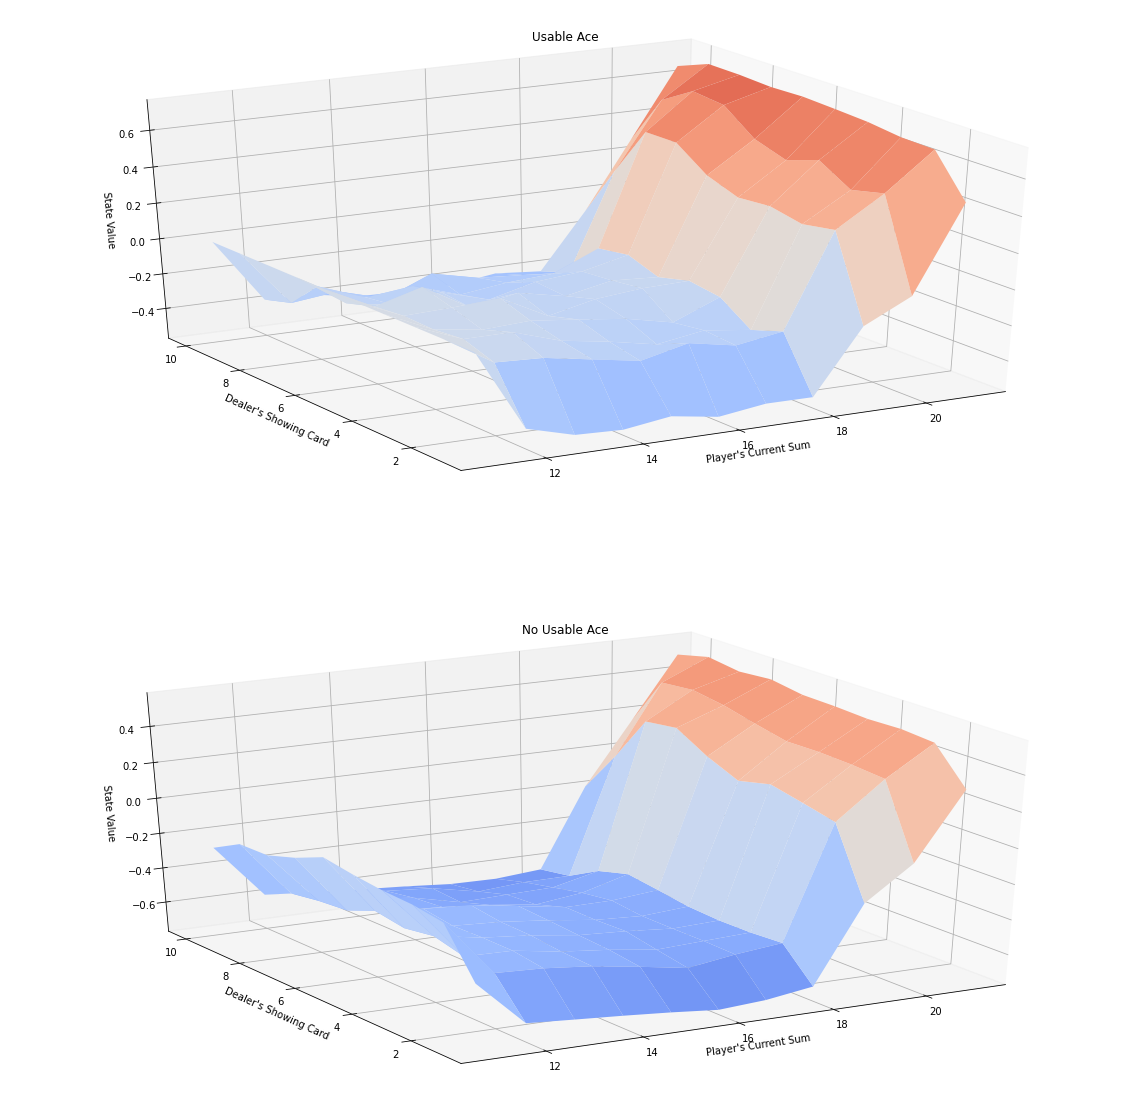

In [8]:
# obtaining the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtaining the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# ploting the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, we will write implementation of constant-$\alpha$ MC control.  

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.



In [27]:
def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon/nA
    policy_s[np.argmax(Q_s)] = (1 - epsilon + epsilon/nA)
    return policy_s
    
def generate_episode_from_policy(env, epsilon, nA, Q):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        # select the best action, apply the action, store the result in episode.
        
        # we have to select from Q[state] action_space using e- greedy policy (or)
        # if the state has not been visited, sample action at random
        if state in Q:
            probs = get_probs(Q[state], epsilon, nA) # probability of occourance of each type of action according to e-greedy pol
            action = np.random.choice(np.arange(nA), p =probs)
        else:
            action = env.action_space.sample() #equiprobable policy

        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode
        

In [28]:
def updateQ(Q, env, episode, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    #extaract states, action, rewards
    states, actions, rewards = zip(*episode)
    #prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)]) #1 extra since there is no discount[:-0]
    for i, state in enumerate(states):
        Gt = sum(rewards[i:]*discounts[:-(i+1)]) 
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(Gt - old_Q)
    return Q

In [35]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start =1.0, eps_decay = 0.9999, eps_min = 0.1):
    nA = env.action_space.n #getting length of action space for future use
    # initializing empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # looping over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        #updating epsilon vlaue
        epsilon = max(epsilon*eps_decay, eps_min) 
        #generating episodes while following epsilon greedy policy
        episode = generate_episode_from_policy(env, epsilon, nA, Q)
        # updating the action-value estimate
        Q = updateQ(Q, env, episode, alpha, gamma)
    
    # determining the policy corresponding to the final action-value function estimate
    opt_policy = dict((state,np.argmax(action_space)) for state,action_space in Q.items()) # policy is dict of state, best action
    return opt_policy, Q

Used the cell below to obtain the estimated optimal policy and action-value function. 

In [36]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 7000000, 0.02)

Episode 7000000/7000000.

Next, we plot the corresponding state-value function.

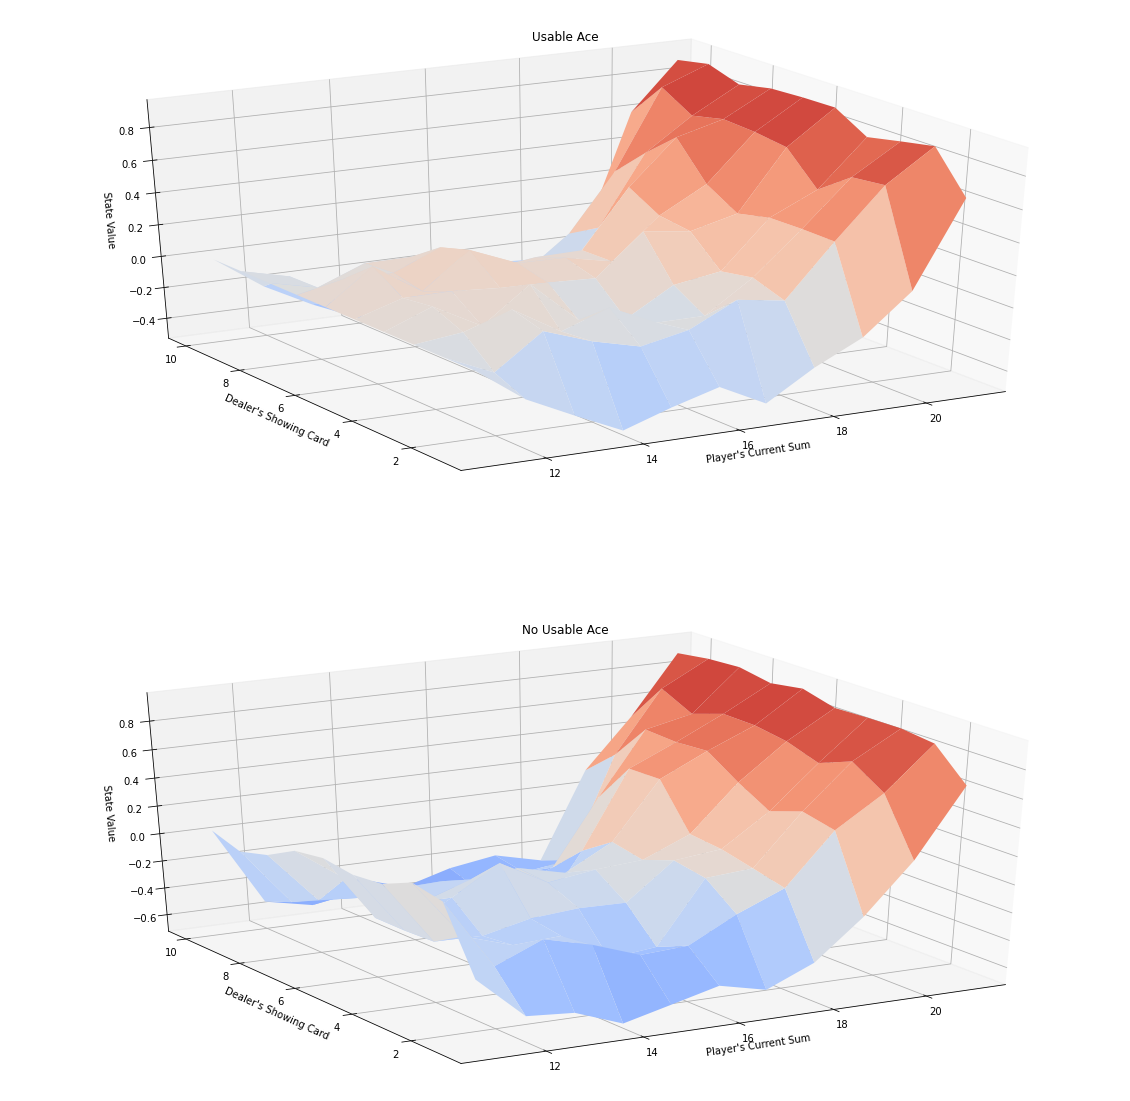

In [37]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

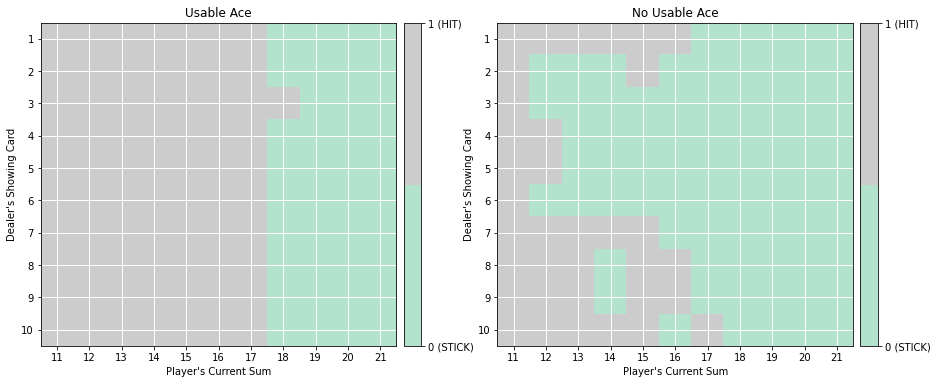

In [38]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  We can compare our final estimate to the optimal policy.
![True Optimal Policy](images/optimal.png)